In [23]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [24]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [25]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [26]:
%matplotlib inline

In [27]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(19001, 28)
(19001, 2)


In [28]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, -0.031441960856, -0.0136477514252, -0.0127038601305,
       -0.00244656498529, 0.00516659590702, 0.014237910934,
       -0.0715826028263, -0.398971193528, 0.000248611213881,
       -0.399555781735, 0.0179192922017, -0.000367993487606,
       0.402828296044, -0.0267053264964, 0.000249471553281,
       0.0463155300908, 0.397264323636, -0.000133312153753, True, False,
       False, True, 0.0, 0.0, 0.0], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [29]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [30]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [31]:
idx_fl_rr_swinging.shape

(9388,)

## Predict CoM -> x

In [32]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, -0.031441960856, -0.0136477514252, -0.0127038601305,
       -0.00244656498529, 0.00516659590702, 0.014237910934,
       -0.0715826028263, -0.398971193528, 0.000248611213881,
       -0.399555781735, 0.0179192922017, -0.000367993487606,
       0.402828296044, -0.0267053264964, 0.000249471553281,
       0.0463155300908, 0.397264323636, -0.000133312153753, True, False,
       False, True, 0.0, 0.0, 0.0], dtype=object)

In [33]:
Y_motion_CoM_FL_RR[0, :]

array([0.009566533575338099, -0.0029288409990329], dtype=object)

### Linear Regression

In [34]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9579965827894007
RMSE:  0.008069782125995153
The lowest error is:  2.4723075754684576e-06
The highest error is:  0.13369800215004765
The avg. error is:  0.00515220987974989


In [35]:
model_fl_com_x.coef_

array([[-0.00715844, -0.00432984,  0.00973717,  0.13993503,  0.00766397,
        -0.00233136, -0.0220862 , -0.02948966,  0.08568462, -0.04609111,
         0.04355563, -0.03165185, -0.22501132,  0.12179569, -0.08592023,
         0.17833885, -0.10248969,  0.30010836, -0.1117295 ,  0.12678388]])

In [36]:
model_fl_com_x.intercept_

array([0.00953473])

In [33]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 14)

Text(0, 0.5, 'Predictions')

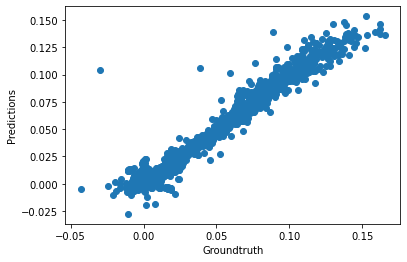

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [38]:
#%store model_fl_com_x

In [39]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [40]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [41]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 3:9],
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8954681012932327
RMSE:  0.007905095509163148
The lowest error is:  2.2102732306350514e-06
The highest error is:  0.11666163743879235
The avg. error is:  0.004859464380119007


In [42]:
model_fl_com_y.coef_

array([[ 0.00257405, -0.00635308,  0.0261515 ,  0.00502916,  0.15059956,
        -0.00209986, -0.00783446, -0.0374507 ,  0.06317577,  0.00095072,
        -0.00270331, -0.05464866, -0.03626144, -0.20389387,  0.05635502,
        -0.04342571, -0.03966529,  0.0598691 ,  0.08277287, -0.12104681]])

In [43]:
model_fl_com_y.intercept_

array([-0.00154338])

Text(0, 0.5, 'Predictions')

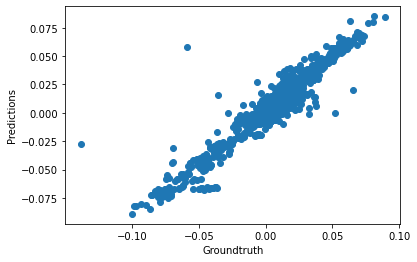

In [44]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [27]:
#%store model_fl_com_y

In [28]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")